In [ ]:
!pip install jax jaxlib
!pip install --quiet --upgrade scipy
!pip install --quiet jax jaxlib optax

In [ ]:
import jax
from jax.scipy.stats import norm
import jax.numpy as jnp
from scipy.stats import norm
import time
import jax.numpy as jnp
from numpy.polynomial.legendre import leggauss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, brentq, minimize
from scipy.special import gamma
from numpy.polynomial.legendre import leggauss
import warnings
warnings.filterwarnings('ignore')
from numpy.random import default_rng
from math import log
from numpy.random import default_rng, SeedSequence
from scipy.stats import kstwobign, cramervonmises, uniform
from joblib import Parallel, delayed
from itertools import zip_longest
from collections import OrderedDict


# ==============================================================
# ETLL ARE Table
# ==============================================================


Table 2: ARE values α=2.0, β=0.5
       0.3    0.5    0.8    1.0    1.3    2.0    5.0    7.0    9.0    10.0
0.3   0.118  0.292  0.761  0.946  0.914  0.555  0.059  0.021  0.002  0.001
0.5   0.112  0.275  0.733  0.944  0.966  0.669  0.119  0.050  0.025  0.019
0.8   0.104  0.253  0.687  0.918  0.997  0.787  0.219  0.117  0.071  0.057
1.0   0.100  0.240  0.657  0.894  0.999  0.839  0.285  0.168  0.110  0.092
1.2   0.096  0.228  0.628  0.866  0.992  0.875  0.346  0.219  0.153  0.130
2.0   0.083  0.191  0.528  0.758  0.924  0.927  0.531  0.397  0.315  0.285
4.0   0.063  0.138  0.374  0.557  0.729  0.840  0.697  0.608  0.543  0.517
5.0   0.057  0.123  0.326  0.490  0.652  0.778  0.707  0.639  0.587  0.565
7.0   0.049  0.100  0.260  0.393  0.536  0.669  0.679  0.642  0.609  0.594
10.0  0.041  0.080  0.200  0.303  0.422  0.546  0.608  0.595  0.580  0.573

⭐ Maximum ARE = 0.999 at a=1.0, b=1.3


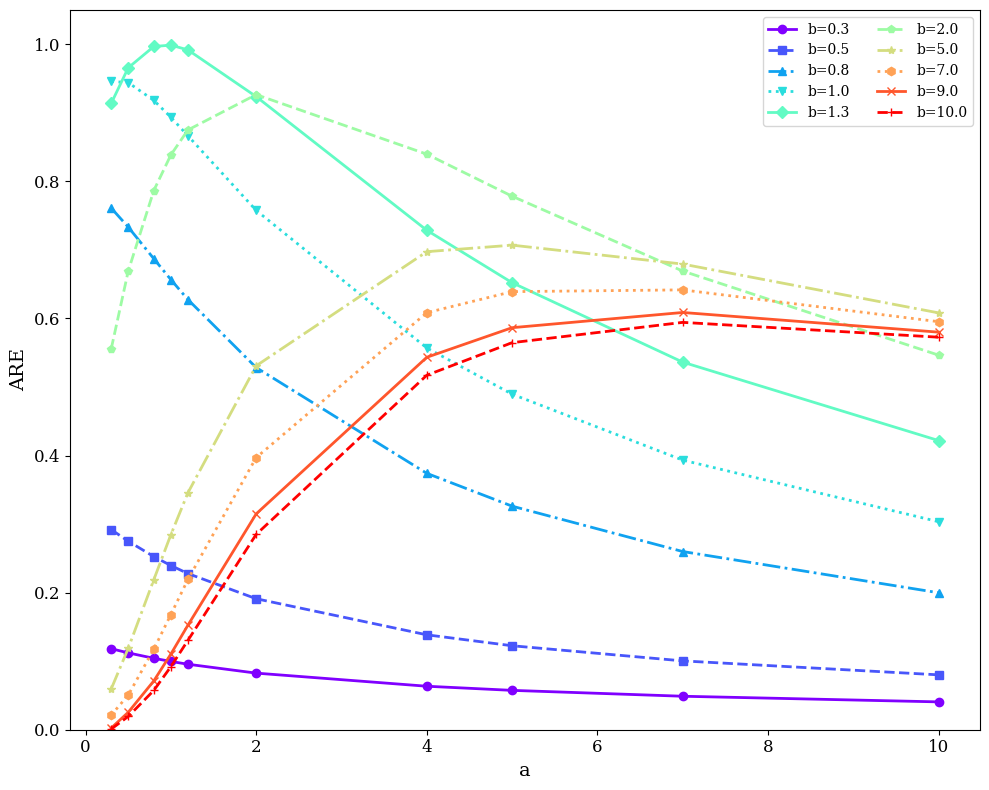


⏱️ Total runtime: 32.65 s


In [ ]:
# ==============================================================
# ETLL ARE Table
# ==============================================================

# ---------- pretty, wide table printing ----------
pd.set_option("display.width", 2000)
pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)


class ETLLARE:
    def __init__(self, theta=1.0, kuma_a=1.0, kuma_b=1.0, n_quad=200):
        self.theta = theta
        self.kuma_a = kuma_a
        self.kuma_b = kuma_b
        self.n_quad = n_quad
        # Precompute Gauss–Legendre nodes & weights
        self.nodes, self.weights = np.polynomial.legendre.leggauss(n_quad)
        # Transform nodes from [-1,1] → [0,1]
        self.u = 0.5 * (self.nodes + 1)
        self.w = 0.5 * self.weights

    def kumaraswamy_weight(self, u, a=None, b=None):
        if a is None: a = self.kuma_a
        if b is None: b = self.kuma_b
        return a * b * (u ** (a - 1)) * ((1 - u**a) ** (b - 1))

    # ---- Ck integral using Gauss–Legendre ----
    def compute_ck(self, beta, k):
        u, w = self.u, self.w
        weights = self.kumaraswamy_weight(u)
        base = 2**beta - (2**beta - 1) * u
        mask = base > 0
        term = np.zeros_like(u)
        term[mask] = base[mask]**(1/beta) - 1
        valid = term > 0
        integrand = np.zeros_like(u)
        integrand[valid] = weights[valid] * (np.log(term[valid])**k)
        return np.sum(w * integrand)

    def tau(self, beta):
        C1 = self.compute_ck(beta, 1)
        C2 = self.compute_ck(beta, 2)
        return C2 - C1**2

    def solve_beta(self, mu1, mu2, beta_range=(-3, 3)):
        Delta = mu2 - mu1**2
        def f(beta):
            C1 = self.compute_ck(beta, 1)
            t = self.tau(beta)
            if t <= 0 or Delta <= 0: return np.nan
            return C1/np.sqrt(t) - (np.log(self.theta)-mu1)/np.sqrt(Delta)

        from scipy.optimize import brentq
        beta_hat = brentq(f, beta_range[0], beta_range[1])
        C1 = self.compute_ck(beta_hat, 1)
        t = self.tau(beta_hat)
        alpha_hat = np.sqrt(t/Delta)
        return alpha_hat, beta_hat

    # ---- Variance–covariance matrix via Λ integrals ----
    def compute_lambda_integral(self, type_num, alpha, beta):
        u, w = self.u, self.w
        weights = self.kumaraswamy_weight(u)

        base = 2**beta - (2**beta - 1) * u
        term = np.where(base > 0, base**(1/beta) - 1, np.nan)
        g = np.where(term > 0, base**(1/beta - 1)/term, 0.0)
        ell = np.where(term > 0, np.log(term), 0.0)

        # kernel K(v,w)
        def kernel(v, w): return np.minimum(v,w) - v*w

        result = 0.0
        for i in range(len(u)):
            for j in range(len(u)):
                if type_num == 1:
                    val = weights[i]*weights[j]*kernel(u[i],u[j])*g[i]*g[j]
                elif type_num == 2:
                    val = weights[i]*weights[j]*kernel(u[i],u[j])*g[i]*ell[j]*g[j]
                elif type_num == 3:
                    val = weights[i]*weights[j]*kernel(u[i],u[j])*ell[i]*g[i]*ell[j]*g[j]
                else:
                    raise ValueError("Invalid type_num")
                result += w[i]*w[j]*val
        return result

    def compute_variance_covariance(self, alpha, beta):
        c = ((2**beta - 1)/(alpha*beta))**2
        L1 = self.compute_lambda_integral(1, alpha, beta)
        L2 = self.compute_lambda_integral(2, alpha, beta)
        L3 = self.compute_lambda_integral(3, alpha, beta)
        Sigma11 = c * L1
        Sigma12 = c * (2*np.log(self.theta)*L1 - 2/alpha*L2)
        Sigma22 = c * (4*np.log(self.theta)**2*L1 - 8*np.log(self.theta)/alpha*L2 + 4/alpha**2*L3)
        return np.array([[Sigma11, Sigma12],[Sigma12, Sigma22]])

    def fisher_information(self, alpha, beta, n):
        t = np.linspace(1e-6, 1-1e-6, 540)
        I_bm1 = np.trapezoid(np.log(t)*(1+t)**(beta-1), t)
        I_bm3_2 = np.trapezoid((np.log(t)**2)*(1+t)**(beta-3), t)
        two_pow_beta = 2**beta; denom = two_pow_beta-1
        Iaa = (1/alpha**2)*(1 - ((beta-1)/(beta-2))*(1+beta+(beta/denom)*(2*beta*I_bm1+(beta-1)*I_bm3_2)))
        Ibb = (1/beta**2)*(1 - (two_pow_beta*beta**2*(np.log(2)**2))/(denom**2))
        Iab = (1/(alpha*(beta-1)))*(1+(beta*I_bm1)/denom)
        return n*np.array([[Iaa,Iab],[Iab,Ibb]])

    # ---- ARE ----
    def compute_ARE(self, mu1, mu2, n):
        alpha_hat, beta_hat = self.solve_beta(mu1, mu2)
        Sigma = self.compute_variance_covariance(alpha_hat, beta_hat)/n

        # Jacobian (finite diff)
        eps = 1e-6
        def get_params(m1,m2):
            try: return self.solve_beta(m1,m2)
            except: return alpha_hat,beta_hat
        alpha_p1,beta_p1 = get_params(mu1+eps,mu2)
        alpha_m1,beta_m1 = get_params(mu1-eps,mu2)
        alpha_p2,beta_p2 = get_params(mu1,mu2+eps)
        alpha_m2,beta_m2 = get_params(mu1,mu2-eps)
        D = np.array([[(alpha_p1-alpha_m1)/(2*eps),(alpha_p2-alpha_m2)/(2*eps)],
                      [(beta_p1-beta_m1)/(2*eps),(beta_p2-beta_m2)/(2*eps)]])
        S_K = D @ Sigma @ D.T
        I = self.fisher_information(alpha_hat, beta_hat, n)
        S_MLE = np.linalg.inv(I)

        det_S_K, det_S_MLE = np.linalg.det(S_K), np.linalg.det(S_MLE)
        ARE_det = np.sqrt(det_S_MLE/det_S_K) if det_S_K>0 else np.nan
        return ARE_det


# ==============================================================
# Generate Table
# ==============================================================

def generate_etll_are_table_and_plot(alpha_true=2.0, beta_true=0.5, n=1000):
    a_values = [0.3, 0.5, 0.8, 1.0, 1.2, 2.0, 4.0, 5.0, 7.0, 10.0]
    b_values = [0.3, 0.5, 0.8, 1.0, 1.3, 2.0, 5.0, 7.0, 9.0, 10.0]

    are_matrix = np.zeros((len(a_values), len(b_values)))

    for i,a in enumerate(a_values):
        for j,b in enumerate(b_values):
            solver = ETLLARE(theta=1.0,kuma_a=a,kuma_b=b)
            # compute population moments with Gauss–Legendre
            u,w = solver.u, solver.w
            q = solver.theta*(( (2**beta_true - (2**beta_true-1)*u )**(1/beta_true) - 1 )**(-1/alpha_true))
            mu1 = np.sum(w*solver.kumaraswamy_weight(u,a,b)*np.log(q))
            mu2 = np.sum(w*solver.kumaraswamy_weight(u,a,b)*(np.log(q)**2))
            are_matrix[i,j] = solver.compute_ARE(mu1,mu2,n)

    df = pd.DataFrame(are_matrix, index=a_values, columns=b_values)
    print("\nTable 2: ARE values α=2.0, β=0.5")
    print(df.round(3))

    # ---- Find max ARE ----
    max_are = np.nanmax(are_matrix)
    max_idx = np.unravel_index(np.nanargmax(are_matrix), are_matrix.shape)
    optimal_a = a_values[max_idx[0]]
    optimal_b = b_values[max_idx[1]]
    print(f"\n⭐ Maximum ARE = {max_are:.3f} at a={optimal_a}, b={optimal_b}")

    # ---- Plot Figure with different line styles ------
    fig, ax = plt.subplots(figsize=(10,8))

    # Define colors and line styles for b values
    colors = plt.cm.rainbow(np.linspace(0,1,len(b_values)))

    # Different line styles for each b value (repeats if more than 4)
    linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--']

    # Different markers for each b value
    markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'x', '+']

    for j,b in enumerate(b_values):
        ax.plot(a_values, are_matrix[:,j],
                linestyle=linestyles[j],
                marker=markers[j],
                markersize=6,
                linewidth=2,
                color=colors[j],
                label=f"b={b}")

    ax.set_xlabel("a", fontsize=14)
    ax.set_ylabel("ARE", fontsize=14)
    ax.set_ylim(0, 1.05)
    ax.grid(False)
    ax.legend(loc="best", ncol=2, fontsize=10)
    ax.tick_params(labelsize=12)

    plt.tight_layout()
    plt.savefig("etll_are_interaction.pdf", dpi=300, bbox_inches='tight')
    plt.savefig("etll_are_interaction.png", dpi=300, bbox_inches='tight')
    plt.show()

    return df, are_matrix


# ==============================================================
# Run
# ==============================================================

if __name__ == "__main__":
    t0 = time.perf_counter()
    df, mat = generate_etll_are_table_and_plot()
    print(f"\n⏱️ Total runtime: {time.perf_counter() - t0:.2f} s")

# ==============================================================
# Implementation of Lognormal ARE Table
# ==============================================================


In [ ]:
# ==============================================================
# Implementation of Lognormal ARE Table
# ==============================================================


class LognormalARE:
    def __init__(self, n_quad_1d=400, n_quad_2d=160, n_quad_1d_dense=1200, n_quad_2d_dense=320):
        # Default quadrature
        x1, w1 = leggauss(n_quad_1d)
        self.u1_default = jnp.array(0.5 * (x1 + 1))
        self.w1_default = jnp.array(0.5 * w1)

        x2, w2 = leggauss(n_quad_2d)
        self.u2_default = jnp.array(0.5 * (x2 + 1))
        self.w2_default = jnp.array(0.5 * w2)

        # Dense quadrature (for small a < 0.8)
        x1d, w1d = leggauss(n_quad_1d_dense)
        self.u1_dense = jnp.array(0.5 * (x1d + 1))
        self.w1_dense = jnp.array(0.5 * w1d)

        x2d, w2d = leggauss(n_quad_2d_dense)
        self.u2_dense = jnp.array(0.5 * (x2d + 1))
        self.w2_dense = jnp.array(0.5 * w2d)

    def kumaraswamy_weight(self, u, a, b):
        return a * b * (u**(a - 1)) * (1 - u**a) ** (b - 1)

    def compute_ck_direct(self, k, a, b, u, w):
        J = self.kumaraswamy_weight(u, a, b)
        z = norm.ppf(u)
        return jnp.sum(w * J * (z**k))

    def compute_ck_transformed(self, k, a, b, u, w):
        alpha = 1.0 / (1.0 - a)
        t = u
        uu = t**alpha
        du_dt = alpha * t ** (alpha - 1)
        J = self.kumaraswamy_weight(uu, a, b) * du_dt
        z = norm.ppf(uu)
        return jnp.sum(w * J * (z**k))

    def compute_ck(self, k, a, b):
        if a >= 0.8:
            return self.compute_ck_direct(k, a, b, self.u1_default, self.w1_default)
        else:
            return self.compute_ck_transformed(k, a, b, self.u1_dense, self.w1_dense)

    def compute_eta(self, a, b):
        c1 = self.compute_ck(1, a, b)
        c2 = self.compute_ck(2, a, b)
        return c2 - c1**2

    def compute_lambdas(self, a, b):
        if a >= 0.8:
            U, V = jnp.meshgrid(self.u2_default, self.u2_default, indexing="ij")
            WU, WV = jnp.meshgrid(self.w2_default, self.w2_default, indexing="ij")
        else:
            U, V = jnp.meshgrid(self.u2_dense, self.u2_dense, indexing="ij")
            WU, WV = jnp.meshgrid(self.w2_dense, self.w2_dense, indexing="ij")

        JU, JV = self.kumaraswamy_weight(U, a, b), self.kumaraswamy_weight(V, a, b)
        ZU, ZV = norm.ppf(U), norm.ppf(V)
        phiU, phiV = norm.pdf(ZU), norm.pdf(ZV)

        K = jnp.minimum(U, V) - U * V
        base = JU * JV * K * (1 / phiU) * (1 / phiV)

        L1 = jnp.sum(WU * WV * base)
        L2 = jnp.sum(WU * WV * base * ZV)
        L3 = jnp.sum(WU * WV * base * ZU * ZV)
        return L1, L2, L3

    def compute_ARE(self, a, b):
        if abs(a - 1.0) < 1e-12 and abs(b - 1.0) < 1e-12:
            return 1.0
        eta = self.compute_eta(a, b)
        if eta <= 1e-12:
            return jnp.nan
        L1, L2, L3 = self.compute_lambdas(a, b)
        CS = L1 * L3 - L2**2
        if CS <= 1e-12:
            return jnp.nan
        ARE = jnp.sqrt((eta**2) / (2 * CS))
        return float(jnp.minimum(ARE, 1.0))


# ==============================================================
# Generate Table
# ==============================================================
def generate_table():
    a_values = [0.3, 0.5, 0.8, 1.0, 1.2, 2.0, 4.0, 5.0, 7.0, 10.0]
    b_values = [0.3, 0.5, 0.8, 1.0, 1.3, 2.0, 5.0, 7.0, 15.0, 20.0]

    calc = LognormalARE()
    results = jnp.zeros((len(a_values), len(b_values)))

    start = time.time()
    for i, a in enumerate(a_values):
        for j, b in enumerate(b_values):
            results = results.at[i, j].set(calc.compute_ARE(a, b))
    elapsed = time.time() - start

    df = pd.DataFrame(
        jnp.array(results),
        index=[f"{a:.1f}" for a in a_values],
        columns=[f"{b:.1f}" for b in b_values],
    )
    print(f"\n✅ Completed in {elapsed:.2f} seconds\n")
    print(df.round(3))
    return df


# ==============================================================
# Validation vs Published Table
# ==============================================================
def validate_lognormal_ARE(computed_df):
    published = {
        (0.3, 0.3): 0.142, (0.3, 0.5): 0.264, (0.3, 0.8): 0.204, (0.3, 1.0): 0.152, (0.3, 1.3): 0.103,
        (0.3, 2.0): 0.053, (0.3, 5.0): 0.017, (0.3, 7.0): 0.014, (0.3, 15.0): 0.013, (0.3, 20.0): 0.014,
        (0.5, 0.5): 0.538, (0.5, 0.8): 0.582, (0.5, 1.0): 0.479, (0.5, 1.3): 0.356,
        (0.5, 2.0): 0.203, (0.5, 5.0): 0.054, (0.5, 7.0): 0.033, (0.5, 15.0): 0.012, (0.5, 20.0): 0.009,
        (0.8, 0.8): 0.962, (0.8, 1.0): 0.950, (0.8, 1.3): 0.846, (0.8, 2.0): 0.623,
        (0.8, 5.0): 0.262, (0.8, 7.0): 0.184, (0.8, 15.0): 0.080, (0.8, 20.0): 0.058,
        (1.0, 1.0): 1.000, (1.0, 0.8): 0.950, (1.0, 1.3): 0.955, (1.0, 2.0): 0.782,
        (1.0, 5.0): 0.412, (1.0, 7.0): 0.314, (1.0, 15.0): 0.164, (1.0, 20.0): 0.128,
        (1.2, 1.3): 0.974, (1.2, 2.0): 0.853, (1.2, 5.0): 0.518, (1.2, 7.0): 0.417,
        (1.2, 15.0): 0.247, (1.2, 20.0): 0.201,
        (2.0, 2.0): 0.844, (2.0, 5.0): 0.672, (2.0, 7.0): 0.599, (2.0, 15.0): 0.449, (2.0, 20.0): 0.401,
        (4.0, 5.0): 0.608, (4.0, 7.0): 0.584, (4.0, 15.0): 0.520, (4.0, 20.0): 0.495,
        (5.0, 5.0): 0.555, (5.0, 7.0): 0.541, (5.0, 15.0): 0.499, (5.0, 20.0): 0.482,
        (7.0, 7.0): 0.467, (7.0, 15.0): 0.446, (7.0, 20.0): 0.437,
        (10.0, 15.0): 0.377, (10.0, 20.0): 0.374
    }

    print("\nVALIDATION AGAINST PUBLISHED TABLE (Lognormal)")
    print("-"*65)
    print(f"{'a':>5} {'b':>5} {'Published':>10} {'Computed':>10} {'Error':>8} {'Status':>8}")
    print("-"*65)

    errors=[]
    for (a,b),pub in published.items():
        try:
            comp = computed_df.loc[f"{a:.1f}", f"{b:.1f}"]
            err = abs(comp-pub)
            errors.append(err)
            status="✓" if err<=0.02 else "⚠"
            print(f"{a:5.1f} {b:5.1f} {pub:10.3f} {comp:10.3f} {err:8.3f} {status:>8}")
        except KeyError:
            continue
    print("-"*65)
    print(f"Mean abs error = {jnp.mean(jnp.array(errors)):.4f}")
    print(f"Max abs error  = {jnp.max(jnp.array(errors)):.4f}")


# ==============================================================
if __name__=="__main__":
    df = generate_table()
    validate_lognormal_ARE(df)
    df.to_csv("table_lognormal_ARE.csv")



✅ Completed in 2.07 seconds

        0.3    0.5    0.8    1.0    1.3    2.0    5.0    7.0   15.0   20.0
0.3   0.196  0.331  0.275  0.213  0.151  0.082  0.024  0.017  0.013  0.014
0.5   0.267  0.560  0.605  0.502  0.378  0.220  0.062  0.038  0.014  0.010
0.8   0.316  0.620  0.962  0.949  0.846  0.623  0.263  0.185  0.082  0.060
1.0   0.279  0.550  0.949  1.000  0.955  0.782  0.411  0.313  0.163  0.127
1.2   0.250  0.488  0.892  0.976  0.973  0.853  0.517  0.416  0.246  0.201
2.0   0.182  0.335  0.662  0.782  0.847  0.844  0.672  0.599  0.449  0.401
4.0   0.120  0.194  0.390  0.488  0.565  0.622  0.608  0.584  0.520  0.495
5.0   0.106  0.162  0.324  0.411  0.483  0.544  0.555  0.541  0.499  0.482
7.0   0.089  0.125  0.243  0.313  0.375  0.434  0.467  0.464  0.446  0.437
10.0  0.075  0.095  0.178  0.232  0.283  0.335  0.377  0.380  0.377  0.374

VALIDATION AGAINST PUBLISHED TABLE (Lognormal)
-----------------------------------------------------------------
    a     b  Published   Comput

# ==============================================================
# ETELL Simulation
# ==============================================================


In [ ]:
class ETLLSimulation:
    """
      - stable expm1/log transforms for beta≈0 and u→{0,1}
      - vectorized Λ integrals
      - robust beta solver (bracket + fallback)
      - MLE valid for beta<0
      - L-estimator uses 1/n Riemann factor (no re-normalization of J)
      - determinant-based RE/ARE (toggleable)
    """

    # ----------------------------- init & quadrature -----------------------------
    def __init__(self, theta=1.0, alpha=2.0, beta=0.5, n_quad=200,
                 use_det_re=True, use_numeric_info=False, rng=None):
        self.theta = float(theta)
        self.alpha_true = float(alpha)
        self.beta_true = float(beta)
        self.use_det_re = bool(use_det_re)
        self.use_numeric_info = bool(use_numeric_info)

        self.nodes, self.weights = leggauss(n_quad)
        self.u = 0.5*(self.nodes + 1.0)   # map [-1,1] -> [0,1]
        self.w = 0.5*self.weights
        self._K = None                   # cache Brownian-bridge kernel
        self.rng = np.random.default_rng(rng)

    # ----------------------------- distributions & transforms -----------------------------
    @staticmethod
    def kumaraswamy_weight(u, a, b):
        # Kumaraswamy pdf on (0,1): ab u^{a-1} (1 - u^a)^{b-1}
        return a*b * (u**(a-1.0)) * ((1.0 - u**a)**(b-1.0))

    def _stable_terms(self, beta, u):
        """
        Return base, t, ell, g for the transform:
          x = ln(base)/beta   (limit beta->0: x = (1-u) ln 2)
          t  = expm1(x)
          ell = log(t) (masked where t<=0)
          g  = [base^(1/beta - 1)] / t = exp(x)/expm1(x) / base = 1/[(1 - e^{-x}) base]
        """
        two_pow_beta = np.exp(beta*np.log(2.0))
        base = two_pow_beta - (two_pow_beta - 1.0) * u

        if abs(beta) < 1e-8:
            x = (1.0 - u) * np.log(2.0)
        else:
            x = np.log(base) / beta

        t = np.expm1(x)
        ell = np.where(t > 0.0, np.log(t), -np.inf)

        ratio = np.empty_like(x)
        small = np.abs(x) < 1e-7
        ratio[~small] = 1.0 / (1.0 - np.exp(-x[~small]))
        ratio[ small] = 1.0 / (x[small] + 1e-30) + 0.5 + x[small]/12.0

        g = ratio / base
        return base, t, ell, g

    def _kernel_matrix(self):
        if self._K is None:
            u = self.u
            self._K = np.minimum(u[:,None], u[None,:]) - (u[:,None]*u[None,:])
        return self._K

    # ----------------------------- quantile & sampling -----------------------------
    def generate_etll_sample(self, n):
        """
        Inverse-transform sampling from ETLL(θ, α, β).
        Uses expm1-stable branch for beta≈0.
        """
        u = self.rng.uniform(0.0, 1.0, int(n))
        if abs(self.beta_true) < 1e-8:
            # limit: [2^β-(2^β-1)u]^(1/β) -> 2^(1-u)
            t = np.expm1((1.0 - u) * np.log(2.0))  # = 2^(1-u) - 1
        else:
            two_pow_beta = np.exp(self.beta_true*np.log(2.0))
            base = two_pow_beta - (two_pow_beta - 1.0) * u
            x = np.log(base)/self.beta_true
            t = np.expm1(x)                         # = base^(1/β) - 1

        x = self.theta * np.power(t, -1.0/self.alpha_true)
        return x

    # ----------------------------- c_k and tau -----------------------------
    def compute_ck(self, beta, k, a, b):
        """c_k(β) = ∫_0^1 J(u;a,b) [log( ([...]^{1/β} -1) )]^k du  (stable)"""
        u, w = self.u, self.w
        J = self.kumaraswamy_weight(u, a, b)
        _, t, ell, _ = self._stable_terms(beta, u)
        mask = t > 0
        if not np.any(mask):
            return np.nan
        if k == 1:
            integrand = J * np.where(mask, ell, 0.0)
        elif k == 2:
            integrand = J * np.where(mask, ell**2, 0.0)
        else:
            raise ValueError("k must be 1 or 2")
        return np.sum(w * integrand)

    def tau(self, beta, a, b):
        c1 = self.compute_ck(beta, 1, a, b)
        c2 = self.compute_ck(beta, 2, a, b)
        return c2 - c1**2

    # ----------------------------- Λ integrals & covariance -----------------------------
    def _lambda_triplet(self, alpha, beta, a, b):
        """
        Vectorized Λ1, Λ2, Λ3 under Brownian-bridge kernel and J(u;a,b).
        """
        u, w = self.u, self.w
        J = self.kumaraswamy_weight(u, a, b)
        _, t, ell, g = self._stable_terms(beta, u)

        mask = t > 0
        g = np.where(mask, g, 0.0)
        ell = np.where(mask, ell, 0.0)

        W = (w*J)[:,None] * (w*J)[None,:]
        K = self._kernel_matrix()

        G      = g[:,None] * g[None,:]
        right  = (ell[None,:] * g[None,:])
        LG_LG  = (ell[:,None]*g[:,None]) * (ell[None,:]*g[None,:])

        L1 = np.sum(W * K * G)
        L2 = np.sum(W * K * (g[:,None] * right))
        L3 = np.sum(W * K * LG_LG)
        return L1, L2, L3

    def Sigma_mu(self, alpha, beta, a, b):
        """
        Asymptotic covariance of (μ̂1, μ̂2) for chosen (a,b),
        per the L-estimation kernel form.
        """
        c = ((np.exp(beta*np.log(2.0)) - 1.0)/(alpha*beta))**2
        L1, L2, L3 = self._lambda_triplet(alpha, beta, a, b)
        logt = np.log(self.theta)
        S11 = c * L1
        S12 = c * (2*logt*L1 - 2/alpha * L2)
        S22 = c * (4*(logt**2)*L1 - 8*logt/alpha * L2 + 4/(alpha**2)*L3)
        S = np.array([[S11, S12], [S12, S22]])
        return 0.5*(S + S.T)

    # ----------------------------- solving beta and alpha from sample L-moments -----------------------------
    def solve_beta(self, mu1, mu2, a, b):
        """
        Solve for β via c1(β)/sqrt(tau(β)) = (log θ - μ1)/sqrt(Δ).
        Brackets on [-4,4] with grid, then brentq; fallback to bounded LSQ.
        """
        Delta = mu2 - mu1**2
        if Delta <= 1e-12:
            return self.beta_true

        target = (np.log(self.theta) - mu1) / np.sqrt(Delta)

        def R(beta):
            c1 = self.compute_ck(beta, 1, a, b)
            t  = self.tau(beta, a, b)
            if not np.isfinite(c1) or t <= 0:
                return np.nan
            return c1/np.sqrt(t) - target

        grid = np.linspace(-3.5, 3.5, 71)
        vals = np.array([R(bi) for bi in grid])
        sgn  = np.sign(vals)
        for i in range(len(grid)-1):
            if np.isfinite(vals[i]) and np.isfinite(vals[i+1]) and sgn[i]*sgn[i+1] < 0:
                return brentq(lambda b: R(b), grid[i], grid[i+1], xtol=1e-7)

        out = minimize_scalar(lambda b: (R(b) if np.isfinite(R(b)) else 1e6)**2,
                              bounds=(-4,4), method='bounded')
        return out.x if out.success else self.beta_true

    # ----------------------------- L-estimator on a sample -----------------------------
    def kumaraswamy_l_estimator(self, x, a, b):
        """
        L-estimator with J(u;a,b) weights.
        IMPORTANT: no re-normalization of J; use (1/n) sum J(i/(n+1)) h(X_{i:n})
        """
        x = np.asarray(x)
        x = x[x >= self.theta]
        n = x.size
        if n < 3:
            return np.nan, np.nan

        xs = np.sort(x)
        i  = np.arange(1, n+1)
        uo = i/(n+1.0)
        J  = self.kumaraswamy_weight(uo, a, b)

        lx  = np.log(xs)
        mu1 = np.mean(J * lx)           # (1/n)*sum J(.) h1
        mu2 = np.mean(J * (lx**2))      # (1/n)*sum J(.) h2

        Delta = mu2 - mu1**2
        if Delta <= 0:
            return np.nan, np.nan

        beta_hat = self.solve_beta(mu1, mu2, a, b)
        t_beta   = self.tau(beta_hat, a, b)
        if not np.isfinite(t_beta) or t_beta <= 0:
            return np.nan, np.nan

        alpha_hat = np.sqrt(t_beta / Delta)
        return alpha_hat, beta_hat

    # ----------------------------- MLE -----------------------------
    def mle_etll(self, x):
        """
        Simple 2D MLE (θ known): maximize ll(α,β).
        Uses stable constant term and allows β<0.
        """
        xv = np.asarray(x)
        xv = xv[xv >= self.theta]
        n = xv.size
        if n < 5:
            return np.nan, np.nan

        def nll(params):
            alpha, beta = params
            if alpha <= 0 or np.abs(beta) > 5:
                return 1e10
            try:
                if abs(beta) < 1e-8:
                    const = -np.log(np.log(2.0))        # ln(β/(2^β-1)) → -ln ln 2
                else:
                    two_b = np.exp(beta*np.log(2.0))
                    const = np.log(np.abs(beta)) - np.log(np.abs(two_b - 1.0))

                ll = n*np.log(alpha) + n*const
                ratio = (self.theta / xv)**alpha
                ll += (beta - 1.0) * np.sum(np.log1p(ratio))
                ll -= (1.0 + alpha) * np.sum(np.log(xv / self.theta))
                return -ll
            except Exception:
                return 1e10

        # crude initials from logs
        lx = np.log(xv); m1 = lx.mean(); m2 = (lx**2).mean()
        alpha0 = 1.0/np.sqrt(max(m2 - m1**2, 1e-4))
        beta0  = np.clip(self.beta_true, -3.0, 3.0)

        try:
            res = minimize(nll, x0=[alpha0, beta0],
                           bounds=[(0.05, 10.0), (-3.0, 3.0)],
                           method="L-BFGS-B")
            if res.success and res.fun < 1e9:
                return res.x[0], res.x[1]
            # fallback
            res = minimize(nll, x0=[self.alpha_true, self.beta_true],
                           bounds=[(0.05, 10.0), (-3.0, 3.0)],
                           method="L-BFGS-B")
            return (res.x[0], res.x[1]) if res.success else (np.nan, np.nan)
        except Exception:
            return np.nan, np.nan

    # ----------------------------- Fisher information (closed-form approx) -----------------------------
    def fisher_information(self, alpha, beta, n):
        """
        Numeric approximations for I_{•,•} as in MLE section.
        (Guard divisions near beta≈1 or 2 if exploring those values.)
        """
        # numeric integrals for I_{β-1}, I_{β-3}^2
        t = np.linspace(1e-6, 1-1e-6, 75)
        I_bm1   = np.trapezoid(np.log(t)    * (1+t)**(beta-1.0), t)
        I_bm3_2 = np.trapezoid((np.log(t)**2) * (1+t)**(beta-3.0), t)

        two_b = np.exp(beta*np.log(2.0))
        denom = two_b - 1.0
        ln2   = np.log(2.0)

        # guards for denominators
        eps = 1e-8
        denom = denom if np.abs(denom) > eps else np.sign(denom)*eps
        b1 = (beta-1.0) if np.abs(beta-1.0) > eps else np.sign(beta-1.0)*eps
        b2 = (beta-2.0) if np.abs(beta-2.0) > eps else np.sign(beta-2.0)*eps

        Iaa = (1/alpha**2) - ((beta-1.0)/b2) * (1 + beta + (beta/denom)*(2*beta*I_bm1 + (beta-1.0)*I_bm3_2))
        Ibb = (1/beta**2) * (1 - (two_b*(beta**2)*(ln2**2))/(denom**2))
        Iab = (1/(alpha*b1)) * (1 + (beta*I_bm1)/denom)

        I = n*np.array([[Iaa, Iab],[Iab, Ibb]])
        return I

    # ----------------------------- Fisher information (Option 1: numeric) -----------------------------
    def fisher_information_numeric(self, alpha, beta, n, n_quad_info=400):
        """
        Numeric expected observed information for (alpha, beta):
          I = n * E_u[ -∂² log f(Q(u); alpha, beta)/∂(alpha,beta)² ],
        where u ~ U(0,1), x = Q(u). Uses Gauss–Legendre quadrature and stable transforms.
        """
        nodes, weights = leggauss(n_quad_info)
        u = 0.5 * (nodes + 1.0)
        w = 0.5 * weights

        # Q(u) via stable transform
        if abs(beta) < 1e-8:
            t = np.expm1((1.0 - u) * np.log(2.0))  # 2^(1-u) - 1
        else:
            two_b = np.exp(beta * np.log(2.0))
            base  = two_b - (two_b - 1.0) * u
            t     = np.expm1(np.log(base) / beta)  # base^(1/beta) - 1
        x = self.theta * np.power(t, -1.0 / alpha)

        # negative log-pdf averaged over quadrature nodes
        def nll_ab(a, b):
            if a <= 0 or abs(b) > 5:
                return np.inf
            ln2b  = b * np.log(2.0)
            two_b = np.exp(ln2b)
            denom = two_b - 1.0
            if abs(denom) < 1e-12:
                denom = np.sign(denom) * 1e-12
            ratio = (self.theta / x) ** a
            logf = (np.log(a) + np.log(abs(b)) - np.log(abs(denom))
                    - np.log(x) + a * np.log(self.theta / x)
                    + (b - 1.0) * np.log1p(ratio))
            return -np.sum(w * logf)

        a0, b0 = float(alpha), float(beta)
        ha = 1e-5 * max(1.0, abs(a0))
        hb = 1e-5 * max(1.0, abs(b0))

        # central finite-difference Hessian of nll_ab
        f00 = nll_ab(a0, b0)
        faa = (nll_ab(a0 + ha, b0) - 2.0 * f00 + nll_ab(a0 - ha, b0)) / (ha * ha)
        fbb = (nll_ab(a0, b0 + hb) - 2.0 * f00 + nll_ab(a0, b0 - hb)) / (hb * hb)
        fab = (nll_ab(a0 + ha, b0 + hb) - nll_ab(a0 + ha, b0 - hb)
               - nll_ab(a0 - ha, b0 + hb) + nll_ab(a0 - ha, b0 - hb)) / (4.0 * ha * hb)

        I_per_obs = np.array([[faa, fab], [fab, fbb]])
        I_per_obs = 0.5 * (I_per_obs + I_per_obs.T) + 1e-12 * np.eye(2)  # symmetrize + ridge
        return n * I_per_obs

    # ----------------------------- ARE (determinant) for given (a,b) -----------------------------
    def _population_mu(self, alpha, beta, a, b):
        """
        Compute population μ1, μ2 for given (α,β) and Kumaraswamy (a,b).
        """
        u, w = self.u, self.w
        two_b = np.exp(beta*np.log(2.0))
        base  = two_b - (two_b - 1.0) * u
        if abs(beta) < 1e-8:
            t = np.expm1((1.0 - u)*np.log(2.0))
        else:
            t = np.expm1(np.log(base)/beta)

        q = self.theta * np.power(t, -1.0/alpha)
        J = self.kumaraswamy_weight(u, a, b)
        mu1 = np.sum(w * J * np.log(q))
        mu2 = np.sum(w * J * (np.log(q)**2))
        return mu1, mu2

    def _jacobian_D(self, mu1, mu2, a, b, alpha_hat, beta_hat):
        """
        Numeric Jacobian D = ∂(α,β)/∂(μ1,μ2) using stable re-solve.
        """
        eps1 = 1e-6 * max(1.0, abs(mu1))
        eps2 = 1e-6 * max(1.0, abs(mu2))
        def solve_pair(m1, m2):
            try:
                b = self.solve_beta(m1, m2, a, b)
                t = self.tau(b, a, b)
                a_hat = np.sqrt(t / max(m2 - m1**2, 1e-12))
                return a_hat, b
            except Exception:
                return alpha_hat, beta_hat

        a_p, b_p = solve_pair(mu1+eps1, mu2)
        a_m, b_m = solve_pair(mu1-eps1, mu2)
        d11 = (a_p - a_m)/(2*eps1)
        d21 = (b_p - b_m)/(2*eps1)

        a_p, b_p = solve_pair(mu1, mu2+eps2)
        a_m, b_m = solve_pair(mu1, mu2-eps2)
        d12 = (a_p - a_m)/(2*eps2)
        d22 = (b_p - b_m)/(2*eps2)

        D = np.array([[d11, d12],[d21, d22]])
        return D

    # original theoretical ARE helper (relies on external ETLLARE class)
    def compute_theoretical_are(self, a, b):
        """
        Use the original ETLLARE-based ARE computation.
        """
        solver = ETLLARE(theta=self.theta, kuma_a=a, kuma_b=b, n_quad=200)

        # population moments at (alpha_true, beta_true)
        u, w = solver.u, solver.w
        q = self.theta * (((2**self.beta_true - (2**self.beta_true - 1)*u)
                          ** (1/self.beta_true) - 1) ** (-1/self.alpha_true))
        J = solver.kumaraswamy_weight(u, a, b)
        mu1 = np.sum(w * J * np.log(q))
        mu2 = np.sum(w * J * (np.log(q)**2))

        # large n for asymptotics
        return solver.compute_ARE(mu1, mu2, n=5000)

    # ----------------------------- simulation with RE ---------------------------------------
    def run_simulation_with_re_se(self, sample_sizes, kuma_params,
                                  n_batches=10, sims_per_batch=100, verbose=True, ref_at="true"):
        """
        For each n:
          - simulate n_batches × sims_per_batch samples
          - compute MLE and K(a,b) estimates
          - batch-level RE via determinant (if use_det_re) or gmarginal (legacy)
          - aggregate means/SEs and RE with its SE across batches
          - asymptotic column uses theoretical ARE (determinant) per (a,b)

        ref_at: "true" (default) uses Σ_MLE at true params for RE reference,
                "batch" uses Σ_MLE at batch mean (ᾱ, β̄).
        """
        all_results = {}
        for n in sample_sizes:
            if verbose:
                print(f"\nRunning n={n} with {n_batches} batches...")

            # precompute ARE∞ for each (a,b) once
            are_inf = { (a,b): self.compute_theoretical_are(a, b) for (a,b) in kuma_params }

            batch_stats = []
            for bidx in range(n_batches):
                if verbose and bidx % 2 == 0:
                    print(f"  Batch {bidx+1}/{n_batches}")

                est = {"MLE": {"alpha": [], "beta": []}}
                for a,b in kuma_params:
                    est[f"K({a},{b})"] = {"alpha": [], "beta": []}

                # simulations in this batch
                for _ in range(sims_per_batch):
                    x = self.generate_etll_sample(n)
                    a_mle, b_mle = self.mle_etll(x)
                    if np.isfinite(a_mle) and np.isfinite(b_mle):
                        est["MLE"]["alpha"].append(a_mle)
                        est["MLE"]["beta"].append(b_mle)
                    for a,b in kuma_params:
                        ak, bk = self.kumaraswamy_l_estimator(x, a, b)
                        if np.isfinite(ak) and np.isfinite(bk):
                            est[f"K({a},{b})"]["alpha"].append(ak)
                            est[f"K({a},{b})"]["beta"].append(bk)

                # per-batch stats
                batch = {}

                def _winsorize_pair(a_vals, b_vals, p=0.01):
                    ax = np.asarray(a_vals, float); bx = np.asarray(b_vals, float)
                    if ax.size < 3:
                        return ax, bx
                    lo = int(np.floor(p*ax.size)); hi = int(np.ceil((1-p)*ax.size))
                    axs = np.sort(ax); bxs = np.sort(bx)
                    a_lo, a_hi = axs[lo], axs[min(hi, ax.size-1)]
                    b_lo, b_hi = bxs[lo], bxs[min(hi, bx.size-1)]
                    ax_cl = np.clip(ax, a_lo, a_hi)
                    bx_cl = np.clip(bx, b_lo, b_hi)
                    return ax_cl, bx_cl

                def det_re(a_list, b_list, S_asymp_mle_ref):
                    vals = np.c_[a_list, b_list]
                    if vals.shape[0] < 3:
                        return np.nan
                    a_vals, b_vals = _winsorize_pair(vals[:,0], vals[:,1])
                    # FIX: compute covariance on shape (N,2) with rowvar=False to get a 2x2 matrix
                    S = np.cov(np.c_[a_vals, b_vals], rowvar=False, ddof=1)
                    S = 0.5*(S + S.T) + 1e-9*np.eye(2)
                    den = np.linalg.det(S)
                    num = np.linalg.det(S_asympt_mle_ref)
                    return np.sqrt(num/den) if den > 0 else np.nan

                # MLE row
                if len(est["MLE"]["alpha"]) > 0:
                    avals = np.array(est["MLE"]["alpha"])
                    bvals = np.array(est["MLE"]["beta"])

                    # choose RE reference point
                    if ref_at == "batch":
                        alpha_ref = float(np.mean(avals))
                        beta_ref  = float(np.mean(bvals))
                    else:  # "true" (default)
                        alpha_ref = self.alpha_true
                        beta_ref  = self.beta_true

                    # build I_ref at the chosen reference
                    if self.use_numeric_info:
                        I_ref = self.fisher_information_numeric(alpha_ref, beta_ref, n)
                    else:
                        I_ref = self.fisher_information(alpha_ref, beta_ref, n)
                    S_asympt_mle_ref = np.linalg.inv(I_ref)

                    batch["MLE"] = {
                        "alpha_mean": np.mean(avals) / self.alpha_true,
                        "alpha_se":   np.std(avals, ddof=1) / (self.alpha_true * np.sqrt(len(avals))),
                        "beta_mean":  np.mean(bvals) / self.beta_true,
                        "beta_se":    np.std(bvals, ddof=1) / (self.beta_true * np.sqrt(len(bvals))),
                        "re":         det_re(avals, bvals, S_asympt_mle_ref),
                        "re_asymptotic": 1.0
                    }

                    # K(a,b) rows
                    for a,b in kuma_params:
                        key = f"K({a},{b})"
                        if len(est[key]["alpha"]) > 0:
                            avals_k = np.array(est[key]["alpha"])
                            bvals_k = np.array(est[key]["beta"])
                            batch[key] = {
                                "alpha_mean": np.mean(avals_k) / self.alpha_true,
                                "alpha_se":   np.std(avals_k, ddof=1) / (self.alpha_true * np.sqrt(len(avals_k))),
                                "beta_mean":  np.mean(bvals_k) / self.beta_true,
                                "beta_se":    np.std(bvals_k, ddof=1) / (self.beta_true * np.sqrt(len(bvals_k))),
                                "re":         det_re(avals_k, bvals_k, S_asympt_mle_ref),
                                "re_asymptotic": self.compute_theoretical_are(a, b)
                            }

                batch_stats.append(batch)

            # aggregate across batches
            final = {}
            keys = set().union(*[b.keys() for b in batch_stats])
            for key in keys:
                def collect(field):
                    vals = [b[key][field] for b in batch_stats if key in b and field in b[key] and np.isfinite(b[key][field])]
                    return np.array(vals)

                a_mean = collect("alpha_mean"); a_se = collect("alpha_se")
                b_mean = collect("beta_mean");  b_se = collect("beta_se")
                re_vals = collect("re")
                re_inf  = collect("re_asymptotic")

                if a_mean.size > 0:
                    final[key] = {
                        "alpha_mean": a_mean.mean(),
                        "alpha_se":   a_se.mean() if a_se.size>0 else np.nan,
                        "beta_mean":  b_mean.mean() if b_mean.size>0 else np.nan,
                        "beta_se":    b_se.mean() if b_se.size>0 else np.nan,
                        "re":         re_vals.mean() if re_vals.size>0 else np.nan,
                        "re_se":      re_vals.std(ddof=1)/np.sqrt(re_vals.size) if re_vals.size>1 else np.nan,
                        "re_asymptotic": (1.0 if key=="MLE" else (re_inf.mean() if re_inf.size>0 else np.nan))
                    }
            all_results[n] = final

            if verbose:
                print(f"  Total simulations (MLE): {n_batches * sims_per_batch}")

        return all_results

    # ----------------------------- pretty printer -----------------------------
    def print_results_table(self, results, sample_sizes, kuma_params):
        print("\n" + "="*120)
        print(f"Table: Standardized MEAN and RE from ETLL(α={self.alpha_true}, β={self.beta_true}, θ={self.theta})")
        print("Entries are mean values (standard errors) \n" +
              f"RE uses {'determinant ratio' if self.use_det_re else 'marginal geometric-mean proxy'}")
        print("="*120)

        col_w, last_w = 14, 10
        header = "KS Par".ljust(14)
        for n in sample_sizes:
            header += f"{f'n={n}':^{col_w*2}}"
        header += f"{'n→∞':^{last_w*2}}"
        print(header)

        sub = "(a,b)".ljust(14)
        for _ in sample_sizes:
            sub += f"{'α̂/α':>{col_w}}{'β̂/β':>{col_w}}"
        sub += f"{'α̂/α':>{last_w}}{'β̂/β':>{last_w}}"
        print(sub)

        # means
        print("\nMEAN VALUES:")
        def row_for(key, label=None):
            lab = (label or key).ljust(14)
            out = lab
            for n in sample_sizes:
                if n in results and key in results[n]:
                    s = results[n][key]
                    out += f"{s['alpha_mean']:5.2f}({(s['alpha_se'] if np.isfinite(s['alpha_se']) else np.nan):.3f})".rjust(col_w)
                    out += f"{s['beta_mean']:5.2f}({(s['beta_se'] if np.isfinite(s['beta_se']) else np.nan):.3f})".rjust(col_w)
                else:
                    out += f"{'---':>{col_w*2}}"
            out += f"{'1.00':>{last_w}}{'1.00':>{last_w}}"
            print(out)

        row_for("MLE", "MLE")
        for a,b in kuma_params:
            key = f"K({a},{b})"
            row_for(key, f"J({a},{b})")

        # RE
        print("\n" + "-"*120)
        print("RELATIVE EFFICIENCY:")
        def re_row(key, label=None):
            lab = (label or key).ljust(14); out = lab
            for n in sample_sizes:
                if n in results and key in results[n]:
                    s = results[n][key]
                    re = s.get("re", np.nan); se = s.get("re_se", np.nan)
                    out += f"{(re if np.isfinite(re) else np.nan):5.3f}({(se if np.isfinite(se) else np.nan):.3f})".rjust(col_w)
                else:
                    out += f"{'---':>{col_w}}"
            # asymptotic
            n0 = sample_sizes[0]
            if n0 in results and key in results[n0]:
                out += f"{results[n0][key]['re_asymptotic']:5.3f}".rjust(last_w)
            else:
                out += f"{'---':>{last_w}}"
            print(out)

        re_row("MLE", "MLE")
        for a,b in kuma_params:
            re_row(f"K({a},{b})", f"J({a},{b})")


# ----------------------------- example runner -----------------------------
def run_etll_simulation_study():
    alpha_true, beta_true, theta_true = 2.0, 0.5, 1.0
    sample_sizes = [100,250,500,1000]
    kuma_params = [
        (1.0, 1.0),
        (0.3, 1.0),
        (1.2, 1.3),
        (0.8, 1.0),
        (4.0, 12.0),
        (2.0, 1.0),
        (5.0, 5.0),
    ]

    print("ETLL Simulation Study")
    print(f"True params: α={alpha_true}, β={beta_true}, θ={theta_true}")

    # Turn on Option 1 (numeric Fisher):
    sim = ETLLSimulation(theta=theta_true, alpha=alpha_true, beta=beta_true,
                                  n_quad=600, use_det_re=True, use_numeric_info=False, rng=123)

    results = sim.run_simulation_with_re_se(
        sample_sizes=sample_sizes,
        kuma_params=kuma_params,
        n_batches=50,
        sims_per_batch=200,
        verbose=True,
        ref_at="true",  # or "batch"
    )

    sim.print_results_table(results, sample_sizes, kuma_params)
    return results

if __name__ == "__main__":
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    t0 = time.perf_counter()
    _ = run_etll_simulation_study()
    print(f"\n⏱️ Total runtime: {time.perf_counter() - t0:.2f} s")

ETLL Simulation Study
True params: α=2.0, β=0.5, θ=1.0

Running n=100 with 50 batches...
  Batch 1/50
  Batch 3/50
  Batch 5/50
  Batch 7/50
  Batch 9/50
  Batch 11/50
  Batch 13/50
  Batch 15/50
  Batch 17/50
  Batch 19/50
  Batch 21/50
  Batch 23/50
  Batch 25/50
  Batch 27/50
  Batch 29/50
  Batch 31/50
  Batch 33/50
  Batch 35/50
  Batch 37/50
  Batch 39/50
  Batch 41/50
  Batch 43/50
  Batch 45/50
  Batch 47/50
  Batch 49/50
  Total simulations (MLE): 10000

Running n=250 with 50 batches...
  Batch 1/50
  Batch 3/50
  Batch 5/50
  Batch 7/50
  Batch 9/50
  Batch 11/50
  Batch 13/50
  Batch 15/50
  Batch 17/50
  Batch 19/50
  Batch 21/50
  Batch 23/50
  Batch 25/50
  Batch 27/50
  Batch 29/50
  Batch 31/50
  Batch 33/50
  Batch 35/50
  Batch 37/50
  Batch 39/50
  Batch 41/50
  Batch 43/50
  Batch 45/50
  Batch 47/50
  Batch 49/50
  Total simulations (MLE): 10000

Running n=500 with 50 batches...
  Batch 1/50
  Batch 3/50
  Batch 5/50
  Batch 7/50
  Batch 9/50
  Batch 11/50
  Batch 

In [ ]:
class ETLLSimulation:
    """
      - stable expm1/log transforms for beta≈0 and u→{0,1}
      - vectorized Λ integrals
      - robust beta solver (bracket + fallback)
      - MLE valid for beta<0
      - L-estimator uses 1/n Riemann factor (no re-normalization of J)
      - determinant-based RE/ARE (toggleable)
    """

    # ----------------------------- init & quadrature -----------------------------
    def __init__(self, theta=1.0, alpha=2.0, beta=0.5, n_quad=200,
                 use_det_re=True, use_numeric_info=False, rng=None):
        self.theta = float(theta)
        self.alpha_true = float(alpha)
        self.beta_true = float(beta)
        self.use_det_re = bool(use_det_re)
        self.use_numeric_info = bool(use_numeric_info)

        self.nodes, self.weights = leggauss(n_quad)
        self.u = 0.5*(self.nodes + 1.0)   # map [-1,1] -> [0,1]
        self.w = 0.5*self.weights
        self._K = None                   # cache Brownian-bridge kernel
        self.rng = np.random.default_rng(rng)

    # ----------------------------- distributions & transforms -----------------------------
    @staticmethod
    def kumaraswamy_weight(u, a, b):
        # Kumaraswamy pdf on (0,1): ab u^{a-1} (1 - u^a)^{b-1}
        return a*b * (u**(a-1.0)) * ((1.0 - u**a)**(b-1.0))

    def _stable_terms(self, beta, u):
        """
        Return base, t, ell, g for the transform:
          x = ln(base)/beta   (limit beta->0: x = (1-u) ln 2)
          t  = expm1(x)
          ell = log(t) (masked where t<=0)
          g  = [base^(1/beta - 1)] / t = exp(x)/expm1(x) / base = 1/[(1 - e^{-x}) base]
        """
        two_pow_beta = np.exp(beta*np.log(2.0))
        base = two_pow_beta - (two_pow_beta - 1.0) * u

        if abs(beta) < 1e-8:
            x = (1.0 - u) * np.log(2.0)
        else:
            x = np.log(base) / beta

        t = np.expm1(x)
        ell = np.where(t > 0.0, np.log(t), -np.inf)

        ratio = np.empty_like(x)
        small = np.abs(x) < 1e-7
        ratio[~small] = 1.0 / (1.0 - np.exp(-x[~small]))
        ratio[ small] = 1.0 / (x[small] + 1e-30) + 0.5 + x[small]/12.0

        g = ratio / base
        return base, t, ell, g

    def _kernel_matrix(self):
        if self._K is None:
            u = self.u
            self._K = np.minimum(u[:,None], u[None,:]) - (u[:,None]*u[None,:])
        return self._K

    # ----------------------------- quantile & sampling -----------------------------
    def generate_etll_sample(self, n):
        """
        Inverse-transform sampling from ETLL(θ, α, β).
        Uses expm1-stable branch for beta≈0.
        """
        u = self.rng.uniform(0.0, 1.0, int(n))
        if abs(self.beta_true) < 1e-8:
            # limit: [2^β-(2^β-1)u]^(1/β) -> 2^(1-u)
            t = np.expm1((1.0 - u) * np.log(2.0))  # = 2^(1-u) - 1
        else:
            two_pow_beta = np.exp(self.beta_true*np.log(2.0))
            base = two_pow_beta - (two_pow_beta - 1.0) * u
            x = np.log(base)/self.beta_true
            t = np.expm1(x)                         # = base^(1/β) - 1

        x = self.theta * np.power(t, -1.0/self.alpha_true)
        return x

    # ----------------------------- c_k and tau -----------------------------
    def compute_ck(self, beta, k, a, b):
        """c_k(β) = ∫_0^1 J(u;a,b) [log( ([...]^{1/β} -1) )]^k du  (stable)"""
        u, w = self.u, self.w
        J = self.kumaraswamy_weight(u, a, b)
        _, t, ell, _ = self._stable_terms(beta, u)
        mask = t > 0
        if not np.any(mask):
            return np.nan
        if k == 1:
            integrand = J * np.where(mask, ell, 0.0)
        elif k == 2:
            integrand = J * np.where(mask, ell**2, 0.0)
        else:
            raise ValueError("k must be 1 or 2")
        return np.sum(w * integrand)

    def tau(self, beta, a, b):
        c1 = self.compute_ck(beta, 1, a, b)
        c2 = self.compute_ck(beta, 2, a, b)
        return c2 - c1**2

    # ----------------------------- Λ integrals & covariance -----------------------------
    def _lambda_triplet(self, alpha, beta, a, b):
        """
        Vectorized Λ1, Λ2, Λ3 under Brownian-bridge kernel and J(u;a,b).
        """
        u, w = self.u, self.w
        J = self.kumaraswamy_weight(u, a, b)
        _, t, ell, g = self._stable_terms(beta, u)

        mask = t > 0
        g = np.where(mask, g, 0.0)
        ell = np.where(mask, ell, 0.0)

        W = (w*J)[:,None] * (w*J)[None,:]
        K = self._kernel_matrix()

        G      = g[:,None] * g[None,:]
        right  = (ell[None,:] * g[None,:])
        LG_LG  = (ell[:,None]*g[:,None]) * (ell[None,:]*g[None,:])

        L1 = np.sum(W * K * G)
        L2 = np.sum(W * K * (g[:,None] * right))
        L3 = np.sum(W * K * LG_LG)
        return L1, L2, L3

    def Sigma_mu(self, alpha, beta, a, b):
        """
        Asymptotic covariance of (μ̂1, μ̂2) for chosen (a,b),
        per the L-estimation kernel form.
        """
        c = ((np.exp(beta*np.log(2.0)) - 1.0)/(alpha*beta))**2
        L1, L2, L3 = self._lambda_triplet(alpha, beta, a, b)
        logt = np.log(self.theta)
        S11 = c * L1
        S12 = c * (2*logt*L1 - 2/alpha * L2)
        S22 = c * (4*(logt**2)*L1 - 8*logt/alpha * L2 + 4/(alpha**2)*L3)
        S = np.array([[S11, S12], [S12, S22]])
        return 0.5*(S + S.T)

    # ----------------------------- solving beta and alpha from sample L-moments -----------------------------
    def solve_beta(self, mu1, mu2, a, b):
        """
        Solve for β via c1(β)/sqrt(tau(β)) = (log θ - μ1)/sqrt(Δ).
        Brackets on [-4,4] with grid, then brentq; fallback to bounded LSQ.
        """
        Delta = mu2 - mu1**2
        if Delta <= 1e-12:
            return self.beta_true

        target = (np.log(self.theta) - mu1) / np.sqrt(Delta)

        def R(beta):
            c1 = self.compute_ck(beta, 1, a, b)
            t  = self.tau(beta, a, b)
            if not np.isfinite(c1) or t <= 0:
                return np.nan
            return c1/np.sqrt(t) - target

        grid = np.linspace(-3.5, 3.5, 71)
        vals = np.array([R(bi) for bi in grid])
        sgn  = np.sign(vals)
        for i in range(len(grid)-1):
            if np.isfinite(vals[i]) and np.isfinite(vals[i+1]) and sgn[i]*sgn[i+1] < 0:
                return brentq(lambda b: R(b), grid[i], grid[i+1], xtol=1e-7)

        out = minimize_scalar(lambda b: (R(b) if np.isfinite(R(b)) else 1e6)**2,
                              bounds=(-4,4), method='bounded')
        return out.x if out.success else self.beta_true

    # ----------------------------- L-estimator on a sample -----------------------------
    def kumaraswamy_l_estimator(self, x, a, b):
        """
        L-estimator with J(u;a,b) weights.
        IMPORTANT: no re-normalization of J; use (1/n) sum J(i/(n+1)) h(X_{i:n})
        """
        x = np.asarray(x)
        x = x[x >= self.theta]
        n = x.size
        if n < 3:
            return np.nan, np.nan

        xs = np.sort(x)
        i  = np.arange(1, n+1)
        uo = i/(n+1.0)
        J  = self.kumaraswamy_weight(uo, a, b)

        lx  = np.log(xs)
        mu1 = np.mean(J * lx)           # (1/n)*sum J(.) h1
        mu2 = np.mean(J * (lx**2))      # (1/n)*sum J(.) h2

        Delta = mu2 - mu1**2
        if Delta <= 0:
            return np.nan, np.nan

        beta_hat = self.solve_beta(mu1, mu2, a, b)
        t_beta   = self.tau(beta_hat, a, b)
        if not np.isfinite(t_beta) or t_beta <= 0:
            return np.nan, np.nan

        alpha_hat = np.sqrt(t_beta / Delta)
        return alpha_hat, beta_hat

    # ----------------------------- MLE -----------------------------
    def mle_etll(self, x):
        """
        Simple 2D MLE (θ known): maximize ll(α,β).
        Uses stable constant term and allows β<0.
        """
        xv = np.asarray(x)
        xv = xv[xv >= self.theta]
        n = xv.size
        if n < 5:
            return np.nan, np.nan

        def nll(params):
            alpha, beta = params
            if alpha <= 0 or np.abs(beta) > 5:
                return 1e10
            try:
                if abs(beta) < 1e-8:
                    const = -np.log(np.log(2.0))        # ln(β/(2^β-1)) → -ln ln 2
                else:
                    two_b = np.exp(beta*np.log(2.0))
                    const = np.log(np.abs(beta)) - np.log(np.abs(two_b - 1.0))

                ll = n*np.log(alpha) + n*const
                ratio = (self.theta / xv)**alpha
                ll += (beta - 1.0) * np.sum(np.log1p(ratio))
                ll -= (1.0 + alpha) * np.sum(np.log(xv / self.theta))
                return -ll
            except Exception:
                return 1e10

        # crude initials from logs
        lx = np.log(xv); m1 = lx.mean(); m2 = (lx**2).mean()
        alpha0 = 1.0/np.sqrt(max(m2 - m1**2, 1e-4))
        beta0  = np.clip(self.beta_true, -3.0, 3.0)

        try:
            res = minimize(nll, x0=[alpha0, beta0],
                           bounds=[(0.05, 10.0), (-3.0, 3.0)],
                           method="L-BFGS-B")
            if res.success and res.fun < 1e9:
                return res.x[0], res.x[1]
            # fallback
            res = minimize(nll, x0=[self.alpha_true, self.beta_true],
                           bounds=[(0.05, 10.0), (-3.0, 3.0)],
                           method="L-BFGS-B")
            return (res.x[0], res.x[1]) if res.success else (np.nan, np.nan)
        except Exception:
            return np.nan, np.nan

    # ----------------------------- Fisher information (closed-form approx) -----------------------------
    def fisher_information(self, alpha, beta, n):
        """
        Numeric approximations for I_{•,•} as in MLE section.
        (Guard divisions near beta≈1 or 2 if exploring those values.)
        """
        # numeric integrals for I_{β-1}, I_{β-3}^2
        t = np.linspace(1e-6, 1-1e-6, 75)
        I_bm1   = np.trapezoid(np.log(t)    * (1+t)**(beta-1.0), t)
        I_bm3_2 = np.trapezoid((np.log(t)**2) * (1+t)**(beta-3.0), t)

        two_b = np.exp(beta*np.log(2.0))
        denom = two_b - 1.0
        ln2   = np.log(2.0)

        # guards for denominators
        eps = 1e-8
        denom = denom if np.abs(denom) > eps else np.sign(denom)*eps
        b1 = (beta-1.0) if np.abs(beta-1.0) > eps else np.sign(beta-1.0)*eps
        b2 = (beta-2.0) if np.abs(beta-2.0) > eps else np.sign(beta-2.0)*eps

        Iaa = (1/alpha**2) - ((beta-1.0)/b2) * (1 + beta + (beta/denom)*(2*beta*I_bm1 + (beta-1.0)*I_bm3_2))
        Ibb = (1/beta**2) * (1 - (two_b*(beta**2)*(ln2**2))/(denom**2))
        Iab = (1/(alpha*b1)) * (1 + (beta*I_bm1)/denom)

        I = n*np.array([[Iaa, Iab],[Iab, Ibb]])
        return I

    # ----------------------------- Fisher information (Option 1: numeric) -----------------------------
    def fisher_information_numeric(self, alpha, beta, n, n_quad_info=400):
        """
        Numeric expected observed information for (alpha, beta):
          I = n * E_u[ -∂² log f(Q(u); alpha, beta)/∂(alpha,beta)² ],
        where u ~ U(0,1), x = Q(u). Uses Gauss–Legendre quadrature and stable transforms.
        """
        nodes, weights = leggauss(n_quad_info)
        u = 0.5 * (nodes + 1.0)
        w = 0.5 * weights

        # Q(u) via stable transform
        if abs(beta) < 1e-8:
            t = np.expm1((1.0 - u) * np.log(2.0))  # 2^(1-u) - 1
        else:
            two_b = np.exp(beta * np.log(2.0))
            base  = two_b - (two_b - 1.0) * u
            t     = np.expm1(np.log(base) / beta)  # base^(1/beta) - 1
        x = self.theta * np.power(t, -1.0 / alpha)

        # negative log-pdf averaged over quadrature nodes
        def nll_ab(a, b):
            if a <= 0 or abs(b) > 5:
                return np.inf
            ln2b  = b * np.log(2.0)
            two_b = np.exp(ln2b)
            denom = two_b - 1.0
            if abs(denom) < 1e-12:
                denom = np.sign(denom) * 1e-12
            ratio = (self.theta / x) ** a
            logf = (np.log(a) + np.log(abs(b)) - np.log(abs(denom))
                    - np.log(x) + a * np.log(self.theta / x)
                    + (b - 1.0) * np.log1p(ratio))
            return -np.sum(w * logf)

        a0, b0 = float(alpha), float(beta)
        ha = 1e-5 * max(1.0, abs(a0))
        hb = 1e-5 * max(1.0, abs(b0))

        # central finite-difference Hessian of nll_ab
        f00 = nll_ab(a0, b0)
        faa = (nll_ab(a0 + ha, b0) - 2.0 * f00 + nll_ab(a0 - ha, b0)) / (ha * ha)
        fbb = (nll_ab(a0, b0 + hb) - 2.0 * f00 + nll_ab(a0, b0 - hb)) / (hb * hb)
        fab = (nll_ab(a0 + ha, b0 + hb) - nll_ab(a0 + ha, b0 - hb)
               - nll_ab(a0 - ha, b0 + hb) + nll_ab(a0 - ha, b0 - hb)) / (4.0 * ha * hb)

        I_per_obs = np.array([[faa, fab], [fab, fbb]])
        I_per_obs = 0.5 * (I_per_obs + I_per_obs.T) + 1e-12 * np.eye(2)  # symmetrize + ridge
        return n * I_per_obs

    # ----------------------------- ARE (determinant) for given (a,b) -----------------------------
    def _population_mu(self, alpha, beta, a, b):
        """
        Compute population μ1, μ2 for given (α,β) and Kumaraswamy (a,b).
        """
        u, w = self.u, self.w
        two_b = np.exp(beta*np.log(2.0))
        base  = two_b - (two_b - 1.0) * u
        if abs(beta) < 1e-8:
            t = np.expm1((1.0 - u)*np.log(2.0))
        else:
            t = np.expm1(np.log(base)/beta)

        q = self.theta * np.power(t, -1.0/alpha)
        J = self.kumaraswamy_weight(u, a, b)
        mu1 = np.sum(w * J * np.log(q))
        mu2 = np.sum(w * J * (np.log(q)**2))
        return mu1, mu2

    def _jacobian_D(self, mu1, mu2, a, b, alpha_hat, beta_hat):
        """
        Numeric Jacobian D = ∂(α,β)/∂(μ1,μ2) using stable re-solve.
        """
        eps1 = 1e-6 * max(1.0, abs(mu1))
        eps2 = 1e-6 * max(1.0, abs(mu2))
        def solve_pair(m1, m2):
            try:
                b = self.solve_beta(m1, m2, a, b)
                t = self.tau(b, a, b)
                a_hat = np.sqrt(t / max(m2 - m1**2, 1e-12))
                return a_hat, b
            except Exception:
                return alpha_hat, beta_hat

        a_p, b_p = solve_pair(mu1+eps1, mu2)
        a_m, b_m = solve_pair(mu1-eps1, mu2)
        d11 = (a_p - a_m)/(2*eps1)
        d21 = (b_p - b_m)/(2*eps1)

        a_p, b_p = solve_pair(mu1, mu2+eps2)
        a_m, b_m = solve_pair(mu1, mu2-eps2)
        d12 = (a_p - a_m)/(2*eps2)
        d22 = (b_p - b_m)/(2*eps2)

        D = np.array([[d11, d12],[d21, d22]])
        return D

    # original theoretical ARE helper (relies on external ETLLARE class)
    def compute_theoretical_are(self, a, b):
        """
        Use the original ETLLARE-based ARE computation.
        """
        solver = ETLLARE(theta=self.theta, kuma_a=a, kuma_b=b, n_quad=200)

        # population moments at (alpha_true, beta_true)
        u, w = solver.u, solver.w
        q = self.theta * (((2**self.beta_true - (2**self.beta_true - 1)*u)
                          ** (1/self.beta_true) - 1) ** (-1/self.alpha_true))
        J = solver.kumaraswamy_weight(u, a, b)
        mu1 = np.sum(w * J * np.log(q))
        mu2 = np.sum(w * J * (np.log(q)**2))

        # large n for asymptotics
        return solver.compute_ARE(mu1, mu2, n=5000)

    # ----------------------------- simulation with RE ---------------------------------------
    def run_simulation_with_re_se(self, sample_sizes, kuma_params,
                                  n_batches=10, sims_per_batch=100, verbose=True, ref_at="true"):
        """
        For each n:
          - simulate n_batches × sims_per_batch samples
          - compute MLE and K(a,b) estimates
          - batch-level RE via determinant (if use_det_re) or gmarginal (legacy)
          - aggregate means/SEs and RE with its SE across batches
          - asymptotic column uses theoretical ARE (determinant) per (a,b)

        ref_at: "true" (default) uses Σ_MLE at true params for RE reference,
                "batch" uses Σ_MLE at batch mean (ᾱ, β̄).
        """
        all_results = {}
        for n in sample_sizes:
            if verbose:
                print(f"\nRunning n={n} with {n_batches} batches...")

            # precompute ARE∞ for each (a,b) once
            are_inf = { (a,b): self.compute_theoretical_are(a, b) for (a,b) in kuma_params }

            batch_stats = []
            for bidx in range(n_batches):
                if verbose and bidx % 2 == 0:
                    print(f"  Batch {bidx+1}/{n_batches}")

                est = {"MLE": {"alpha": [], "beta": []}}
                for a,b in kuma_params:
                    est[f"K({a},{b})"] = {"alpha": [], "beta": []}

                # simulations in this batch
                for _ in range(sims_per_batch):
                    x = self.generate_etll_sample(n)
                    a_mle, b_mle = self.mle_etll(x)
                    if np.isfinite(a_mle) and np.isfinite(b_mle):
                        est["MLE"]["alpha"].append(a_mle)
                        est["MLE"]["beta"].append(b_mle)
                    for a,b in kuma_params:
                        ak, bk = self.kumaraswamy_l_estimator(x, a, b)
                        if np.isfinite(ak) and np.isfinite(bk):
                            est[f"K({a},{b})"]["alpha"].append(ak)
                            est[f"K({a},{b})"]["beta"].append(bk)

                # per-batch stats
                batch = {}

                def _winsorize_pair(a_vals, b_vals, p=0.01):
                    ax = np.asarray(a_vals, float); bx = np.asarray(b_vals, float)
                    if ax.size < 3:
                        return ax, bx
                    lo = int(np.floor(p*ax.size)); hi = int(np.ceil((1-p)*ax.size))
                    axs = np.sort(ax); bxs = np.sort(bx)
                    a_lo, a_hi = axs[lo], axs[min(hi, ax.size-1)]
                    b_lo, b_hi = bxs[lo], bxs[min(hi, bx.size-1)]
                    ax_cl = np.clip(ax, a_lo, a_hi)
                    bx_cl = np.clip(bx, b_lo, b_hi)
                    return ax_cl, bx_cl

                def det_re(a_list, b_list, S_asymp_mle_ref):
                    vals = np.c_[a_list, b_list]
                    if vals.shape[0] < 3:
                        return np.nan
                    a_vals, b_vals = _winsorize_pair(vals[:,0], vals[:,1])
                    # FIX: compute covariance on shape (N,2) with rowvar=False to get a 2x2 matrix
                    S = np.cov(np.c_[a_vals, b_vals], rowvar=False, ddof=1)
                    S = 0.5*(S + S.T) + 1e-9*np.eye(2)
                    den = np.linalg.det(S)
                    num = np.linalg.det(S_asympt_mle_ref)
                    return np.sqrt(num/den) if den > 0 else np.nan

                # MLE row
                if len(est["MLE"]["alpha"]) > 0:
                    avals = np.array(est["MLE"]["alpha"])
                    bvals = np.array(est["MLE"]["beta"])

                    # choose RE reference point
                    if ref_at == "batch":
                        alpha_ref = float(np.mean(avals))
                        beta_ref  = float(np.mean(bvals))
                    else:  # "true" (default)
                        alpha_ref = self.alpha_true
                        beta_ref  = self.beta_true

                    # build I_ref at the chosen reference
                    if self.use_numeric_info:
                        I_ref = self.fisher_information_numeric(alpha_ref, beta_ref, n)
                    else:
                        I_ref = self.fisher_information(alpha_ref, beta_ref, n)
                    S_asympt_mle_ref = np.linalg.inv(I_ref)

                    batch["MLE"] = {
                        "alpha_mean": np.mean(avals) / self.alpha_true,
                        "alpha_se":   np.std(avals, ddof=1) / (self.alpha_true * np.sqrt(len(avals))),
                        "beta_mean":  np.mean(bvals) / self.beta_true,
                        "beta_se":    np.std(bvals, ddof=1) / (self.beta_true * np.sqrt(len(bvals))),
                        "re":         det_re(avals, bvals, S_asympt_mle_ref),
                        "re_asymptotic": 1.0
                    }

                    # K(a,b) rows
                    for a,b in kuma_params:
                        key = f"K({a},{b})"
                        if len(est[key]["alpha"]) > 0:
                            avals_k = np.array(est[key]["alpha"])
                            bvals_k = np.array(est[key]["beta"])
                            batch[key] = {
                                "alpha_mean": np.mean(avals_k) / self.alpha_true,
                                "alpha_se":   np.std(avals_k, ddof=1) / (self.alpha_true * np.sqrt(len(avals_k))),
                                "beta_mean":  np.mean(bvals_k) / self.beta_true,
                                "beta_se":    np.std(bvals_k, ddof=1) / (self.beta_true * np.sqrt(len(bvals_k))),
                                "re":         det_re(avals_k, bvals_k, S_asympt_mle_ref),
                                "re_asymptotic": self.compute_theoretical_are(a, b)
                            }

                batch_stats.append(batch)

            # aggregate across batches
            final = {}
            keys = set().union(*[b.keys() for b in batch_stats])
            for key in keys:
                def collect(field):
                    vals = [b[key][field] for b in batch_stats if key in b and field in b[key] and np.isfinite(b[key][field])]
                    return np.array(vals)

                a_mean = collect("alpha_mean"); a_se = collect("alpha_se")
                b_mean = collect("beta_mean");  b_se = collect("beta_se")
                re_vals = collect("re")
                re_inf  = collect("re_asymptotic")

                if a_mean.size > 0:
                    final[key] = {
                        "alpha_mean": a_mean.mean(),
                        "alpha_se":   a_se.mean() if a_se.size>0 else np.nan,
                        "beta_mean":  b_mean.mean() if b_mean.size>0 else np.nan,
                        "beta_se":    b_se.mean() if b_se.size>0 else np.nan,
                        "re":         re_vals.mean() if re_vals.size>0 else np.nan,
                        "re_se":      re_vals.std(ddof=1)/np.sqrt(re_vals.size) if re_vals.size>1 else np.nan,
                        "re_asymptotic": (1.0 if key=="MLE" else (re_inf.mean() if re_inf.size>0 else np.nan))
                    }
            all_results[n] = final

            if verbose:
                print(f"  Total simulations (MLE): {n_batches * sims_per_batch}")

        return all_results

    # ----------------------------- pretty printer -----------------------------
    def print_results_table(self, results, sample_sizes, kuma_params):
        print("\n" + "="*120)
        print(f"Table: Standardized MEAN and RE from ETLL(α={self.alpha_true}, β={self.beta_true}, θ={self.theta})")
        print("Entries are mean values (standard errors) \n" +
              f"RE uses {'determinant ratio' if self.use_det_re else 'marginal geometric-mean proxy'}")
        print("="*120)

        col_w, last_w = 14, 10
        header = "KS Par".ljust(14)
        for n in sample_sizes:
            header += f"{f'n={n}':^{col_w*2}}"
        header += f"{'n→∞':^{last_w*2}}"
        print(header)

        sub = "(a,b)".ljust(14)
        for _ in sample_sizes:
            sub += f"{'α̂/α':>{col_w}}{'β̂/β':>{col_w}}"
        sub += f"{'α̂/α':>{last_w}}{'β̂/β':>{last_w}}"
        print(sub)

        # means
        print("\nMEAN VALUES:")
        def row_for(key, label=None):
            lab = (label or key).ljust(14)
            out = lab
            for n in sample_sizes:
                if n in results and key in results[n]:
                    s = results[n][key]
                    out += f"{s['alpha_mean']:5.2f}({(s['alpha_se'] if np.isfinite(s['alpha_se']) else np.nan):.3f})".rjust(col_w)
                    out += f"{s['beta_mean']:5.2f}({(s['beta_se'] if np.isfinite(s['beta_se']) else np.nan):.3f})".rjust(col_w)
                else:
                    out += f"{'---':>{col_w*2}}"
            out += f"{'1.00':>{last_w}}{'1.00':>{last_w}}"
            print(out)

        row_for("MLE", "MLE")
        for a,b in kuma_params:
            key = f"K({a},{b})"
            row_for(key, f"J({a},{b})")

        # RE
        print("\n" + "-"*120)
        print("RELATIVE EFFICIENCY:")
        def re_row(key, label=None):
            lab = (label or key).ljust(14); out = lab
            for n in sample_sizes:
                if n in results and key in results[n]:
                    s = results[n][key]
                    re = s.get("re", np.nan); se = s.get("re_se", np.nan)
                    out += f"{(re if np.isfinite(re) else np.nan):5.3f}({(se if np.isfinite(se) else np.nan):.3f})".rjust(col_w)
                else:
                    out += f"{'---':>{col_w}}"
            # asymptotic
            n0 = sample_sizes[0]
            if n0 in results and key in results[n0]:
                out += f"{results[n0][key]['re_asymptotic']:5.3f}".rjust(last_w)
            else:
                out += f"{'---':>{last_w}}"
            print(out)

        re_row("MLE", "MLE")
        for a,b in kuma_params:
            re_row(f"K({a},{b})", f"J({a},{b})")


# ----------------------------- example runner -----------------------------
def run_etll_simulation_study():
    alpha_true, beta_true, theta_true = 2.0, 0.5, 1.0
    sample_sizes = [1000, 3000, 5000]
    kuma_params = [(4.0, 12.0)]

    print("ETLL Simulation Study")
    print(f"True params: α={alpha_true}, β={beta_true}, θ={theta_true}")

    # Turn on Option 1 (numeric Fisher):
    sim = ETLLSimulation(theta=theta_true, alpha=alpha_true, beta=beta_true,
                                  n_quad=600, use_det_re=True, use_numeric_info=False, rng=123)

    results = sim.run_simulation_with_re_se(
        sample_sizes=sample_sizes,
        kuma_params=kuma_params,
        n_batches=50,
        sims_per_batch=200,
        verbose=True,
        ref_at="true",  # or "batch"
    )

    sim.print_results_table(results, sample_sizes, kuma_params)
    return results

if __name__ == "__main__":
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    _ = run_etll_simulation_study()


ETLL Simulation Study
True params: α=2.0, β=0.5, θ=1.0

Running n=1000 with 50 batches...
  Batch 1/50
  Batch 3/50
  Batch 5/50
  Batch 7/50
  Batch 9/50
  Batch 11/50
  Batch 13/50
  Batch 15/50
  Batch 17/50
  Batch 19/50
  Batch 21/50
  Batch 23/50
  Batch 25/50
  Batch 27/50
  Batch 29/50
  Batch 31/50
  Batch 33/50
  Batch 35/50
  Batch 37/50
  Batch 39/50
  Batch 41/50
  Batch 43/50
  Batch 45/50
  Batch 47/50
  Batch 49/50
  Total simulations (MLE): 10000

Running n=3000 with 50 batches...
  Batch 1/50
  Batch 3/50
  Batch 5/50
  Batch 7/50
  Batch 9/50
  Batch 11/50
  Batch 13/50
  Batch 15/50
  Batch 17/50
  Batch 19/50
  Batch 21/50
  Batch 23/50
  Batch 25/50
  Batch 27/50
  Batch 29/50
  Batch 31/50
  Batch 33/50
  Batch 35/50
  Batch 37/50
  Batch 39/50
  Batch 41/50
  Batch 43/50
  Batch 45/50
  Batch 47/50
  Batch 49/50
  Total simulations (MLE): 10000

Running n=5000 with 50 batches...
  Batch 1/50
  Batch 3/50
  Batch 5/50
  Batch 7/50
  Batch 9/50
  Batch 11/50
  Bat